In [1]:
import pandas as pd
from DS_Helpers.filters import column_filter
from DS_Helpers.data import EmbeddingCreator, other_generator, other_generator_columns, find_embed_object_cols
from DS_Helpers.metrics import classification_result
from DS_Helpers.models import pipeline_Classifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, make_scorer, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
help(precision_recall_curve)

Help on function precision_recall_curve in module sklearn.metrics._ranking:

precision_recall_curve(
    y_true,
    y_score=None,
    *,
    pos_label=None,
    sample_weight=None,
    drop_intermediate=False,
    probas_pred='deprecated'
)
    Compute precision-recall pairs for different probability thresholds.

    Note: this implementation is restricted to the binary classification task.

    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.

    The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
    true positives and ``fn`` the number of false negatives. The recall is
    intuitively the ability of the classifier to find all the positive samples.

    The last precision and recall values are 1. and 0. respectively and do not
    have a corresponding thresh

In [3]:
help(column_filter)

Help on function column_filter in module DS_Helpers.filters:

column_filter(df, tolerance=0.5)
    This is a function that fitlers out columns based on the % of missing values

    Inputs:
    df        : A pandas data frame
    tolerance : the % of missing values that can pe tolerated. If the % is higher or equal to this percent then the column shall be removed

    Outputs:
    A pandas data frame minus the columns whose % of missing values was higher or equal to the tolerance



In [4]:
leads = column_filter(pd.read_csv('data/leads_dataset.csv'), tolerance=0.3)
leads.LEAD_CREATED_AT_UTC = pd.to_datetime(leads.LEAD_CREATED_AT_UTC)


infutor_enrichment_dataset = column_filter(pd.read_csv('data/infutor_enrichment_dataset.csv', index_col=0), tolerance=0.3)
zip_code_dataset = column_filter(pd.read_csv('data/zip_code_dataset.csv'), tolerance=0.3)

In [5]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308960 entries, 0 to 308959
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   HASHED_PHONE_NUMBER          308960 non-null  object             
 1   IS_APPOINTMENT_SET           305859 non-null  object             
 2   LEAD_CREATED_AT_UTC          305859 non-null  datetime64[ns, UTC]
 3   ZIP_CODE                     305859 non-null  float64            
 4   CITY                         305822 non-null  object             
 5   STATE                        305822 non-null  object             
 6   COUNTY                       305822 non-null  object             
 7   EMAIL_DOMAIN                 305859 non-null  object             
 8   OPERATINGSYSTEMCLASS         305842 non-null  object             
 9   OPERATINGSYSTEMNAME          305842 non-null  object             
 10  AGENTNAME                    305

In [6]:
leads.head()

,HASHED_PHONE_NUMBER,IS_APPOINTMENT_SET,LEAD_CREATED_AT_UTC,ZIP_CODE,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,AGENTNAME,AGENTVERSIONMAJOR,DEVICEBRAND,DEVICENAME,LAYOUTENGINENAME,NETWORKTYPE,OPERATINGSYSTEMVERSIONMAJOR,WEBVIEWAPPNAME
0,16bc446a779996bf3007065819f1dd4692a17d14,True,2023-07-18 15:11:55+00:00,61080.0,South Beloit,IL,Winnebago,gmail.com,Mobile,Android,Chrome Webview,114,Samsung,Samsung SM-A546V,Blink,Unknown,13,Newsbreak
1,6d30f0d0f87d39f8c178e3750072eef79bb9d7a0,False,2022-09-19 18:37:21+00:00,33914.0,Cape Coral,FL,Lee,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,15,Facebook App for iOS
2,9de207ef32d3696829ae369c2a9a4500cd36ec43,True,2022-11-09 21:38:10+00:00,42055.0,Kuttawa,KY,Lyon,gmail.com,Mobile,Android,Chrome Webview,105,Samsung,Samsung SM-G991U,Blink,Unknown,12,Facebook App for Android
3,31bb43ece722562df3a163ba94be4eb2ccd1bf71,False,2022-11-13 15:41:31+00:00,43701.0,Zanesville,OH,Muskingum,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,15,Facebook App for iOS
4,674de0e7b4da1c9945422b248f94cbf2499d59e2,False,2022-10-07 17:56:51+00:00,22206.0,Arlington,VA,Arlington,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,16,Facebook App for iOS


<Axes: xlabel='IS_APPOINTMENT_SET'>

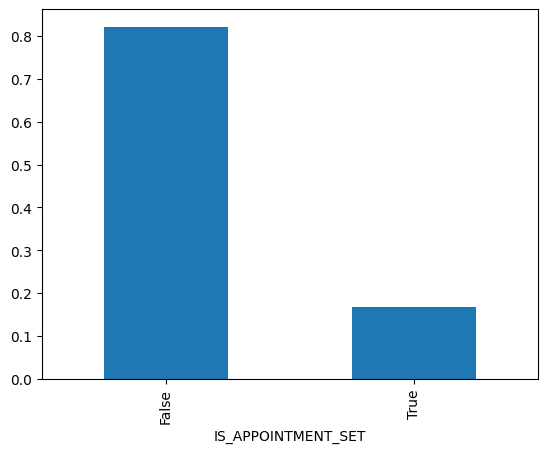

In [7]:
(leads.IS_APPOINTMENT_SET.value_counts()/leads.shape[0]).plot.bar()

In [8]:
infutor_enrichment_dataset.dtypes

HASHED_PHONE_NUMBER                                      object
MATCHLEVEL                                                int64
ATTRIBUTES_COREDEMOGRAPHICS_DOB                         float64
ATTRIBUTES_COREDEMOGRAPHICS_GENDER                       object
ATTRIBUTES_COREDEMOGRAPHICS_MARRIEDCD                    object
ATTRIBUTES_COREDEMOGRAPHICS_WEALTHSCR                    object
ATTRIBUTES_COREDEMOGRAPHICS_HOMEOWNERCD                  object
ATTRIBUTES_COREDEMOGRAPHICS_EHI                          object
ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_LOR                 float64
ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_HHNBR               float64
ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_CENS_POP_DENSITY    float64
dtype: object

In [9]:
infutor_enrichment_dataset.head()

,HASHED_PHONE_NUMBER,MATCHLEVEL,ATTRIBUTES_COREDEMOGRAPHICS_DOB,ATTRIBUTES_COREDEMOGRAPHICS_GENDER,ATTRIBUTES_COREDEMOGRAPHICS_MARRIEDCD,ATTRIBUTES_COREDEMOGRAPHICS_WEALTHSCR,ATTRIBUTES_COREDEMOGRAPHICS_HOMEOWNERCD,ATTRIBUTES_COREDEMOGRAPHICS_EHI,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_LOR,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_HHNBR,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_CENS_POP_DENSITY
0,9a99e383ee68a51c2740de9883f5b1bee5d2a4da,1,197010.0,M,M,A,H,J,6.0,2.0,3801.0
1,0020b0a911711b66c100d7e8e25e226783bb0072,5,194702.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,d436912ed29db2950ca13b64cc56fefc0f581f7a,1,196410.0,F,M,E,H,I,9.0,2.0,294.0
3,c2bd44a987bc7b9663352235ea2b7bb04b696697,5,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c363fb2c7bbdd728928716b4d5b4a80a13cbd2f2,1,197009.0,M,S,D,U,E,15.0,2.0,NaN


In [10]:
zip_code_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19692 entries, 0 to 19691
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ZIP_CODE            19691 non-null  float64
 1   Alchemist           19691 non-null  float64
 2   Ancient Apparition  19691 non-null  float64
 3   Anti-Mage           19691 non-null  float64
 4   Axe                 19691 non-null  float64
 5   Batrider            19691 non-null  float64
 6   Beastmaster         19691 non-null  float64
 7   Chaos Knight        19691 non-null  float64
 8   Chen                19691 non-null  float64
 9   Clinkz              19691 non-null  float64
 10  Clockwerk           19691 non-null  float64
 11  Crystal Maiden      19691 non-null  float64
 12  Dark Seer           19691 non-null  float64
 13  Dazzle              19691 non-null  float64
 14  Death Prophet       19691 non-null  float64
 15  Doom                19691 non-null  float64
 16  Drag

In [11]:
zip_code_dataset.head()

,ZIP_CODE,Alchemist,Ancient Apparition,Anti-Mage,Axe,Batrider,Beastmaster,Chaos Knight,Chen,Clinkz,...,Dragon Knight,Drow Ranger,Earth Spirit,Earthshaker,Elder Titan,Ember Spirit,Enchantress,Enigma,Faceless Void,Pudge
0,47327.0,2065.0,1403.0,40.5,42.1,18.0,7.0,93.0,62.0,26.0,...,1081.0,840.0,16.0,14.0,25.0,12.0,76.0,83.0,3.0,1952.0
1,71268.0,347.0,257.0,40.6,40.6,17.0,7.0,93.0,62.0,34.0,...,1205.0,910.0,21.0,21.0,31.0,16.0,90.0,74.0,0.0,1991.0
2,27828.0,3581.0,2519.0,39.2,38.8,17.0,10.0,90.0,59.0,29.0,...,1533.0,1288.0,24.0,20.0,34.0,21.0,68.0,73.0,3.0,1990.0
3,30143.0,7863.0,5681.0,46.4,49.5,27.0,2.0,98.0,75.0,29.0,...,2654.0,2445.0,9.0,9.0,14.0,9.0,79.0,84.0,1.0,1994.0
4,25564.0,90.0,77.0,37.4,36.8,20.0,2.0,98.0,77.0,16.0,...,1545.0,1125.0,0.0,22.0,0.0,0.0,80.0,68.0,0.0,1987.0


In [12]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308960 entries, 0 to 308959
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   HASHED_PHONE_NUMBER          308960 non-null  object             
 1   IS_APPOINTMENT_SET           305859 non-null  object             
 2   LEAD_CREATED_AT_UTC          305859 non-null  datetime64[ns, UTC]
 3   ZIP_CODE                     305859 non-null  float64            
 4   CITY                         305822 non-null  object             
 5   STATE                        305822 non-null  object             
 6   COUNTY                       305822 non-null  object             
 7   EMAIL_DOMAIN                 305859 non-null  object             
 8   OPERATINGSYSTEMCLASS         305842 non-null  object             
 9   OPERATINGSYSTEMNAME          305842 non-null  object             
 10  AGENTNAME                    305

In [13]:
leads.HASHED_PHONE_NUMBER.value_counts()

HASHED_PHONE_NUMBER
52dc1f49f405383db66d0f3f33a0dd6449d2e6de    861
cd2bab79e874cace82d4ba36e4c5a84bb76826bc    235
6e317ac9c24576beaeb44321d4d85366114098c9    174
d1a2ada48a7171c10e963e6c6a69fe7331d6ba21    102
45b4f5de0dd881af43281854825b7a9d129bca42     78
                                           ... 
7b643af72088c34523fce21619d79098135e5a6c      1
c373159874ccd90aa36ea24744370223e1a017b8      1
cb38c6ba1d10d5b174f59dee7aafc8052b5229da      1
be23195d212e2b456aa13baddf45fdb5336a27aa      1
42fd9f05fc9ff382fed3bb52db39d1538b84b33c      1
Name: count, Length: 276269, dtype: int64

In [14]:
leads.ZIP_CODE.value_counts()

ZIP_CODE
77449.0    445
37042.0    444
77494.0    386
77084.0    361
77373.0    356
          ... 
36769.0      1
21840.0      1
76519.0      1
33137.0      1
35966.0      1
Name: count, Length: 18808, dtype: int64

In [15]:
leads.CITY.value_counts()

CITY
Houston          7235
Las Vegas        3139
Cleveland        3123
Chicago          2563
Columbus         2186
                 ... 
Kenwood             1
New Salisbury       1
Sparks              1
Pine Hill           1
Benham              1
Name: count, Length: 9739, dtype: int64

In [16]:
leads.COUNTY.value_counts()

COUNTY
Harris        12761
Wayne          6082
Montgomery     5814
Clark          5363
Cook           5121
              ...  
Pettis            1
Latah             1
Carver            1
Oktibbeha         1
Yankton           1
Name: count, Length: 1459, dtype: int64

In [17]:
leads.EMAIL_DOMAIN.value_counts()

EMAIL_DOMAIN
gmail.com             135623
yahoo.com              64243
aol.com                22462
hotmail.com            15859
comcast.net             8711
                       ...  
montcopa.org               1
fellowshiphome.net         1
gmail.comhub               1
nlcrealty.com              1
tpa-pa.com                 1
Name: count, Length: 10086, dtype: int64

In [18]:
leads.OPERATINGSYSTEMNAME.value_counts()

OPERATINGSYSTEMNAME
iOS           163139
Android       103080
Windows NT     26967
Mac OS          9295
FireOS          1959
Chrome OS       1182
Linux            198
Ubuntu            17
Tizen              2
Hacker             2
Orbis OS           1
Name: count, dtype: int64

In [19]:
leads.AGENTNAME.value_counts()

AGENTNAME
UIWebView                  96239
Chrome Webview             72594
Chrome                     45858
Safari                     44719
Instagram                  17273
                           ...  
musical_ly_20.3.0 JsSdk        1
musical_ly_20.7.1 JsSdk        1
musical_ly_18.6.5 JsSdk        1
musical_ly_19.3.0 JsSdk        1
AvastSecureBrowser             1
Name: count, Length: 181, dtype: int64

In [20]:
leads.AGENTVERSIONMAJOR.value_counts()

AGENTVERSIONMAJOR
605    95521
16     24932
15     16833
103     9934
114     9681
       ...  
135        1
179        1
48         1
153        1
195        1
Name: count, Length: 261, dtype: int64

In [21]:
leads.IS_APPOINTMENT_SET.isna().sum()

np.int64(3101)

In [22]:
leads = leads[ ~leads.IS_APPOINTMENT_SET.isna() ]

In [23]:
leads.IS_APPOINTMENT_SET.isna().sum()

np.int64(0)

In [24]:
y = leads.IS_APPOINTMENT_SET
X = leads.drop(labels='IS_APPOINTMENT_SET', axis=1)
X

,HASHED_PHONE_NUMBER,LEAD_CREATED_AT_UTC,ZIP_CODE,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,AGENTNAME,AGENTVERSIONMAJOR,DEVICEBRAND,DEVICENAME,LAYOUTENGINENAME,NETWORKTYPE,OPERATINGSYSTEMVERSIONMAJOR,WEBVIEWAPPNAME
0,16bc446a779996bf3007065819f1dd4692a17d14,2023-07-18 15:11:55+00:00,61080.0,South Beloit,IL,Winnebago,gmail.com,Mobile,Android,Chrome Webview,114,Samsung,Samsung SM-A546V,Blink,Unknown,13,Newsbreak
1,6d30f0d0f87d39f8c178e3750072eef79bb9d7a0,2022-09-19 18:37:21+00:00,33914.0,Cape Coral,FL,Lee,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,15,Facebook App for iOS
2,9de207ef32d3696829ae369c2a9a4500cd36ec43,2022-11-09 21:38:10+00:00,42055.0,Kuttawa,KY,Lyon,gmail.com,Mobile,Android,Chrome Webview,105,Samsung,Samsung SM-G991U,Blink,Unknown,12,Facebook App for Android
3,31bb43ece722562df3a163ba94be4eb2ccd1bf71,2022-11-13 15:41:31+00:00,43701.0,Zanesville,OH,Muskingum,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,15,Facebook App for iOS
4,674de0e7b4da1c9945422b248f94cbf2499d59e2,2022-10-07 17:56:51+00:00,22206.0,Arlington,VA,Arlington,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,16,Facebook App for iOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308955,85580be57f0c2e3785ffe5b6187441487915513b,2023-07-10 13:55:13+00:00,2151.0,Revere,MA,Suffolk,yahoo.com,Mobile,iOS,Chrome,114,Apple,Apple iPhone,AppleWebKit,Unknown,16,Unknown
308956,8e7eed2ca3dd2e5a0f27fb3288e0157471a5f81b,2023-05-12 13:54:23+00:00,3867.0,Rochester,NH,Strafford,icloud.com,Desktop,Mac OS,Safari,16,Apple,Apple Macintosh,AppleWebKit,Unknown,10.15,Unknown
308957,f1864c915f0cdf097a794f50a027f84af31f79b2,2023-04-25 20:08:59+00:00,89084.0,North Las Vegas,NV,Clark,juno.com,Mobile,Android,Chrome Webview,112,Samsung,Samsung SM-G981V,Blink,Unknown,13,Facebook App for Android
308958,e69897a60b18857a0e63558f3a86051321f16acf,2023-02-02 20:22:57+00:00,44663.0,New Philadelphia,OH,Tuscarawas,live.com,Mobile,Android,Chrome,104,Samsung,Samsung SM-S901U,Blink,Unknown,13,Unknown


In [ ]:
X = other_generator_columns(df=X, other_threshold=1000)
X.head()

In [ ]:
X = X.drop('HASHED_PHONE_NUMBER ZIP_CODE'.split(), axis=1)
X.head()

,LEAD_CREATED_AT_UTC,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,AGENTNAME,AGENTVERSIONMAJOR,DEVICEBRAND,DEVICENAME,LAYOUTENGINENAME,NETWORKTYPE,OPERATINGSYSTEMVERSIONMAJOR,WEBVIEWAPPNAME
0,2023-07-18 15:11:55+00:00,other,IL,other,gmail.com,Mobile,Android,Chrome Webview,114,Samsung,other,Blink,Unknown,13,Newsbreak
1,2022-09-19 18:37:21+00:00,other,FL,Lee,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,15,Facebook App for iOS
2,2022-11-09 21:38:10+00:00,other,KY,other,gmail.com,Mobile,Android,Chrome Webview,105,Samsung,Samsung SM-G991U,Blink,Unknown,12,Facebook App for Android
3,2022-11-13 15:41:31+00:00,other,OH,other,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,15,Facebook App for iOS
4,2022-10-07 17:56:51+00:00,other,VA,other,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,16,Facebook App for iOS


In [ ]:
X['Year'] = X.LEAD_CREATED_AT_UTC.dt.year
X['Month'] = X.LEAD_CREATED_AT_UTC.dt.month.astype('str')
X['Weekday'] = X.LEAD_CREATED_AT_UTC.dt.weekday.astype('str')
X['Day'] = X.LEAD_CREATED_AT_UTC.dt.day.astype('str')
X['Hour'] = X.LEAD_CREATED_AT_UTC.dt.hour.astype('str')
X = X.drop(labels='LEAD_CREATED_AT_UTC',axis=1)

In [ ]:
X.head()

,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,AGENTNAME,AGENTVERSIONMAJOR,DEVICEBRAND,DEVICENAME,LAYOUTENGINENAME,NETWORKTYPE,OPERATINGSYSTEMVERSIONMAJOR,WEBVIEWAPPNAME,Year,Month,Weekday,Day,Hour
0,other,IL,other,gmail.com,Mobile,Android,Chrome Webview,114,Samsung,other,Blink,Unknown,13,Newsbreak,2023,7,1,18,15
1,other,FL,Lee,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,15,Facebook App for iOS,2022,9,0,19,18
2,other,KY,other,gmail.com,Mobile,Android,Chrome Webview,105,Samsung,Samsung SM-G991U,Blink,Unknown,12,Facebook App for Android,2022,11,2,9,21
3,other,OH,other,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,15,Facebook App for iOS,2022,11,6,13,15
4,other,VA,other,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,16,Facebook App for iOS,2022,10,4,7,17


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
y_counts =  y_train.value_counts()
y_counts


sample_size = int(y_counts.iloc[0] - y_counts.iloc[1])
sample_size

true_sample = X_train[y_train==True].sample(n=sample_size, replace=True)
X_train_oversampled = pd.concat(objs=[X_train, true_sample])


y_train_sample =y_train[ y_train==True ].sample(n=sample_size, replace=True)
y_train_oversampled = pd.concat(objs=(y_train, y_train_sample))

X_train_oversampled, _, y_train_oversampled, _ = train_test_split(X_train_oversampled, y_train_oversampled, test_size=1, random_state=42)

X_train_oversampled = X_train_oversampled.reset_index(drop=True)

y_train_oversampled = y_train_oversampled.reset_index(drop=True)

In [ ]:
X_train.head()

,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,AGENTNAME,AGENTVERSIONMAJOR,DEVICEBRAND,DEVICENAME,LAYOUTENGINENAME,NETWORKTYPE,OPERATINGSYSTEMVERSIONMAJOR,WEBVIEWAPPNAME,Year,Month,Weekday,Day,Hour
77886,other,NJ,Middlesex,msn.com,Desktop,Mac OS,Safari,16,Apple,Apple Macintosh,AppleWebKit,Unknown,>=10.15,Unknown,2023,5,4,12,16
181730,other,IN,other,att.net,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,16,Facebook App for iOS,2023,2,0,13,22
308739,other,IN,other,hotmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,15,Facebook App for iOS,2022,7,4,29,20
209248,other,FL,other,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,16,Facebook App for iOS,2023,3,3,2,21
90431,other,MI,Wayne,gmail.com,Mobile,Android,Chrome Webview,104,other,other,Blink,Unknown,11,Facebook App for Android,2022,9,4,9,16


In [ ]:
X_train_oversampled.head()

,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,AGENTNAME,AGENTVERSIONMAJOR,DEVICEBRAND,DEVICENAME,LAYOUTENGINENAME,NETWORKTYPE,OPERATINGSYSTEMVERSIONMAJOR,WEBVIEWAPPNAME,Year,Month,Weekday,Day,Hour
0,other,OH,other,gmail.com,Mobile,Android,Chrome Webview,113,LG,other,Blink,Unknown,10,Newsbreak,2023,5,4,19,0
1,other,IL,Cook,yahoo.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,15,Google Search App,2022,8,5,6,15
2,other,OH,Butler,gmail.com,Desktop,Windows NT,Edge,101,Unknown,Desktop,Blink,Unknown,>=10,Unknown,2022,5,4,13,21
3,other,FL,Marion,other,Desktop,Windows NT,Chrome,105,Unknown,Desktop,Blink,Unknown,>=10,Unknown,2023,2,2,8,18
4,other,TN,other,gmail.com,Mobile,Android,Chrome,105,Motorola,other,Blink,Unknown,10,Unknown,2022,9,6,18,16


<Axes: xlabel='IS_APPOINTMENT_SET'>

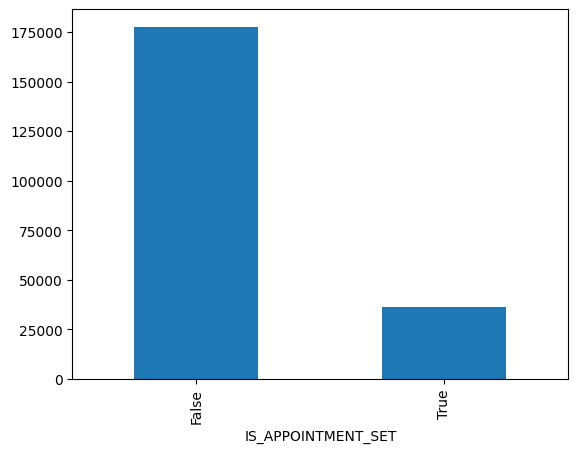

In [ ]:
y_train.value_counts().plot.bar()

<Axes: xlabel='IS_APPOINTMENT_SET'>

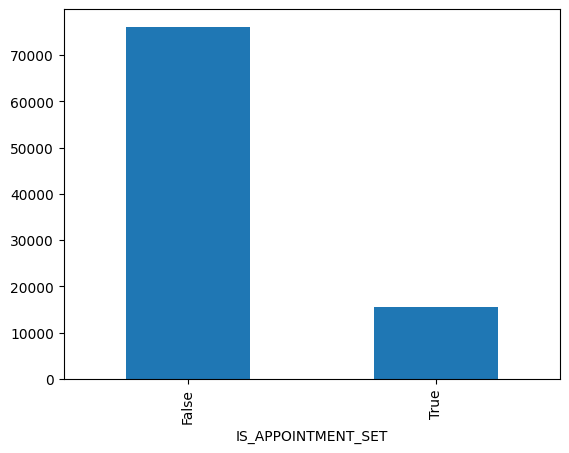

In [ ]:
y_test.value_counts().plot.bar()

<Axes: xlabel='IS_APPOINTMENT_SET'>

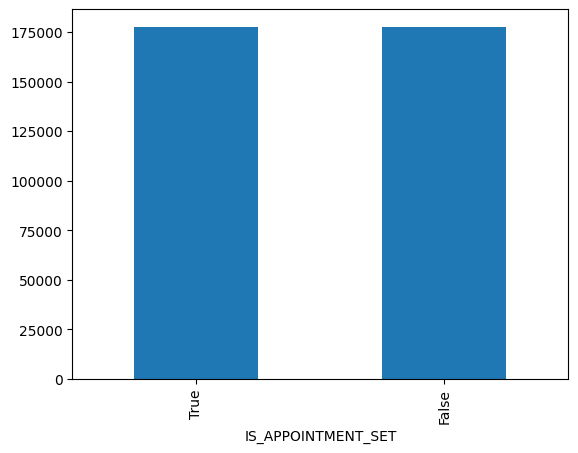

In [ ]:
y_train_oversampled.value_counts().plot.bar()

In [ ]:
obj_embed = find_embed_object_cols(df=X_train, embedding_dims=16)

X_train_embed = obj_embed['df']
X_train_embed

CITY
STATE
COUNTY
EMAIL_DOMAIN
OPERATINGSYSTEMCLASS
OPERATINGSYSTEMNAME
AGENTNAME
AGENTVERSIONMAJOR
DEVICEBRAND
DEVICENAME
LAYOUTENGINENAME
NETWORKTYPE
OPERATINGSYSTEMVERSIONMAJOR
WEBVIEWAPPNAME
Month
Weekday
Day
Hour


,Year,CITY_V_0,CITY_V_1,CITY_V_2,CITY_V_3,CITY_V_4,CITY_V_5,CITY_V_6,CITY_V_7,CITY_V_8,...,Hour_V_6,Hour_V_7,Hour_V_8,Hour_V_9,Hour_V_10,Hour_V_11,Hour_V_12,Hour_V_13,Hour_V_14,Hour_V_15
77886,2023,416,417,418,419,420,421,422,423,424,...,134,135,136,137,138,139,140,141,142,143
181730,2023,416,417,418,419,420,421,422,423,424,...,246,247,248,249,250,251,252,253,254,255
308739,2022,416,417,418,419,420,421,422,423,424,...,214,215,216,217,218,219,220,221,222,223
209248,2023,416,417,418,419,420,421,422,423,424,...,230,231,232,233,234,235,236,237,238,239
90431,2022,416,417,418,419,420,421,422,423,424,...,134,135,136,137,138,139,140,141,142,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230753,2023,416,417,418,419,420,421,422,423,424,...,134,135,136,137,138,139,140,141,142,143
165093,2023,416,417,418,419,420,421,422,423,424,...,262,263,264,265,266,267,268,269,270,271
80600,2023,416,417,418,419,420,421,422,423,424,...,102,103,104,105,106,107,108,109,110,111
70364,2023,320,321,322,323,324,325,326,327,328,...,134,135,136,137,138,139,140,141,142,143


In [ ]:
y_train.isna().mean()

np.float64(0.0)

In [ ]:
model = RandomForestClassifier(n_jobs=-1)
# model = deepcopy(pipeline_Classifier)
# model = GradientBoostingClassifier()

model.fit(X=X_train_embed, y=y_train.astype(str))

RandomForestClassifier(n_jobs=-1)

In [ ]:
X_test_embeding = X_test.copy()

embedings = obj_embed['embedings']

key = list(embedings.keys())[0]

for key in embedings.keys():

    embeding_df = embedings[key].transform( X_test_embeding[key] )
    embeding_df.index = X_test_embeding.index
    X_test_embeding = pd.concat( objs=[X_test_embeding, embeding_df], axis=1 )
    X_test_embeding = X_test_embeding.drop(labels=key, axis=1)

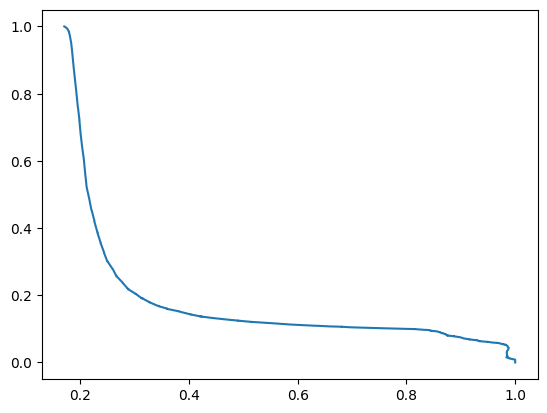

In [ ]:
probs = model.predict_proba(X_test_embeding)

result = precision_recall_curve(
                        y_true=y_test.astype(int).values
                       , probas_pred=probs[:,1])

plt.plot(result[0], result[1])

              precision    recall  f1-score   support

       False       0.84      0.99      0.91     76142
        True       0.69      0.11      0.18     15616

    accuracy                           0.84     91758
   macro avg       0.77      0.55      0.55     91758
weighted avg       0.82      0.84      0.79     91758



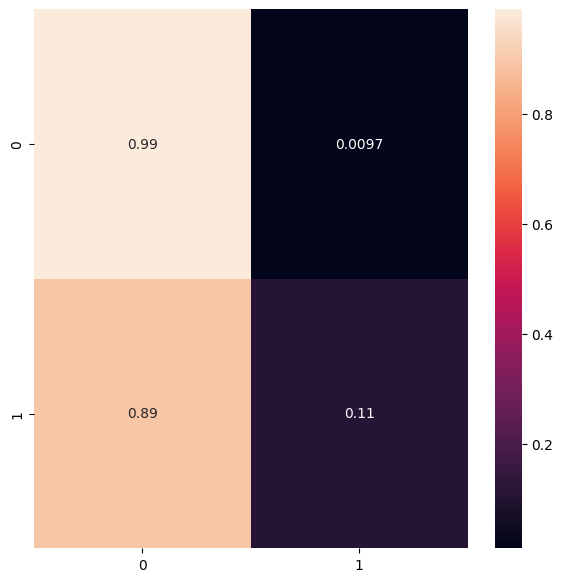

In [ ]:
y_pred = model.predict(X_test_embeding)
classification_result(y_true=y_test.astype(str), y_pred=y_pred)

In [ ]:
obj_embed = find_embed_object_cols(df=X_train_oversampled, embedding_dims=16)

X_train_embed = obj_embed['df']
X_train_embed

CITY
STATE
COUNTY
EMAIL_DOMAIN
OPERATINGSYSTEMCLASS
OPERATINGSYSTEMNAME
AGENTNAME
AGENTVERSIONMAJOR
DEVICEBRAND
DEVICENAME
LAYOUTENGINENAME
NETWORKTYPE
OPERATINGSYSTEMVERSIONMAJOR
WEBVIEWAPPNAME
Month
Weekday
Day
Hour


,Year,CITY_V_0,CITY_V_1,CITY_V_2,CITY_V_3,CITY_V_4,CITY_V_5,CITY_V_6,CITY_V_7,CITY_V_8,...,Hour_V_6,Hour_V_7,Hour_V_8,Hour_V_9,Hour_V_10,Hour_V_11,Hour_V_12,Hour_V_13,Hour_V_14,Hour_V_15
0,2023,416,417,418,419,420,421,422,423,424,...,6,7,8,9,10,11,12,13,14,15
1,2022,416,417,418,419,420,421,422,423,424,...,118,119,120,121,122,123,124,125,126,127
2,2022,416,417,418,419,420,421,422,423,424,...,230,231,232,233,234,235,236,237,238,239
3,2023,416,417,418,419,420,421,422,423,424,...,166,167,168,169,170,171,172,173,174,175
4,2022,416,417,418,419,420,421,422,423,424,...,134,135,136,137,138,139,140,141,142,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355322,2023,416,417,418,419,420,421,422,423,424,...,214,215,216,217,218,219,220,221,222,223
355323,2022,416,417,418,419,420,421,422,423,424,...,118,119,120,121,122,123,124,125,126,127
355324,2023,416,417,418,419,420,421,422,423,424,...,102,103,104,105,106,107,108,109,110,111
355325,2023,416,417,418,419,420,421,422,423,424,...,166,167,168,169,170,171,172,173,174,175


In [ ]:
model = RandomForestClassifier(n_jobs=-1)
# model = deepcopy(pipeline_Classifier)
# model = GradientBoostingClassifier()

model.fit(X=X_train_embed, y=y_train_oversampled.astype(str))

RandomForestClassifier(n_jobs=-1)

In [ ]:
X_test_embeding = X_test.copy()

embedings = obj_embed['embedings']

key = list(embedings.keys())[0]

for key in embedings.keys():

    embeding_df = embedings[key].transform( X_test_embeding[key] )
    embeding_df.index = X_test_embeding.index
    X_test_embeding = pd.concat( objs=[X_test_embeding, embeding_df], axis=1 )
    X_test_embeding = X_test_embeding.drop(labels=key, axis=1)

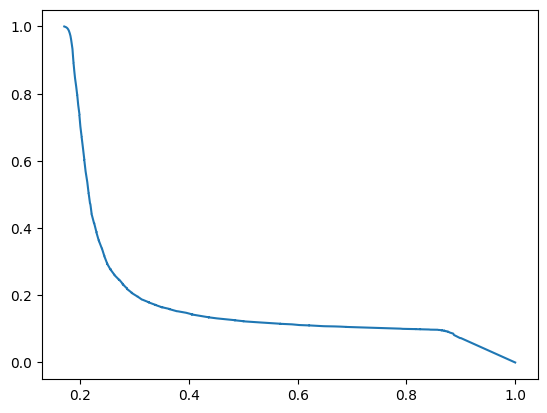

In [ ]:
probs = model.predict_proba(X_test_embeding)

result = precision_recall_curve(
                        y_true=y_test.astype(int).values
                       , probas_pred=probs[:,1])

plt.plot(result[0], result[1])

              precision    recall  f1-score   support

       False       0.84      0.97      0.90     76142
        True       0.45      0.13      0.20     15616

    accuracy                           0.82     91758
   macro avg       0.65      0.55      0.55     91758
weighted avg       0.78      0.82      0.78     91758



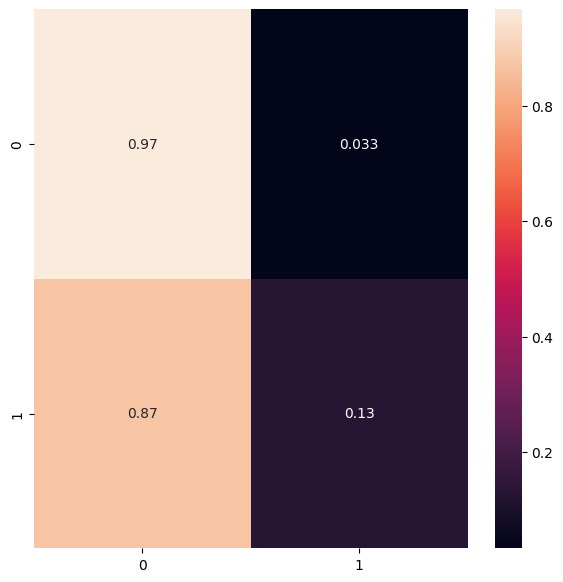

In [ ]:
y_pred = model.predict(X_test_embeding)
classification_result(y_true=y_test.astype(str), y_pred=y_pred)